### Install and import packages

In [1]:
# Import packages
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_palette("tab10")

import random as rnd
import numpy as np
rnd.seed(0)
np.random.seed(0)

import scipy.stats as stats
import bayes_logistic

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import pyro.distributions.constraints as constraints
from pyro.nn import PyroModule, PyroSample

from utils import *

### Set parameters

In [2]:
# Set parameters
# data_x parameters
num_data = 2
num_data_half = num_data // 2
num_feats = 2

# num_samples 
num_samples = 1000

# weights prior distribution parameters
weights_prior_params = [
    [0.0, 0.0], [[50.0, 0.0], [0.0, 50.0]]]


### Generate data_x

In [3]:
# Generate data_x
# data_x = stats.uniform.rvs(0, 1, size=(num_data, num_feats), random_state=12345)
data_x = np.array([[0, 1], [1, 0]])
print(data_x)
print(data_x.shape)

[[0 1]
 [1 0]]
(2, 2)


### Generate prior and posterior samples

Generate two set of prior samples A and B

$$
\begin{align*}
    & A = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta) \\
    & B = \{ \theta_i \}_{i=1}^N, \; \theta_i \sim p(\theta)
\end{align*}
$$

Generate a set of posterior from prior samples A

Notes: 
- $x$ is fixed and generated from the above procedure. Only $y_i$ is generated from $\theta_i$.

$$
\begin{align*}
    & C' = \{ \theta_i' \}_{i=1}^N, \\
    & \theta_i' \sim p(\theta|x, y_i), \\
    & y_i \sim p(y_i|x, \theta_i), \; \theta_i \in A
\end{align*}
$$

In [4]:
### Generate prior and posterior samples

# weights' prior distribution
weights_prior_dist_a = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=1)
weights_prior_dist_b = stats.multivariate_normal(
    weights_prior_params[0], weights_prior_params[1], seed=11)

def logreg_model(x, y):
    num_data, num_feats = x.shape
    # set prior  
    w = pyro.sample("w", dist.MultivariateNormal(
        torch.tensor(weights_prior_params[0], dtype=torch.float).reshape(1, num_feats),
        torch.tensor(weights_prior_params[1], dtype=torch.float)).to_event(1))
    
    # compute ymean and sample
    logit = torch.sigmoid(torch.matmul(x, w.squeeze(1).T)).squeeze(-1)
    with pyro.plate("data", x.shape[0]):
        pyro.sample("y", dist.Bernoulli(logit), obs=y)
        
def logreg_guide(x, y):
    num_data, num_feats = x.shape
    w_loc = pyro.param("w_loc", torch.tensor(weights_prior_params[0], dtype=torch.float).reshape(1, num_feats))
    w_scale = pyro.param('w_scale', torch.tensor(weights_prior_params[1], dtype=torch.float))
    w = pyro.sample('w', dist.MultivariateNormal(w_loc, w_scale).to_event(1))

data_x_torch = torch.tensor(data_x, dtype=torch.float)

samples_a_weights_prior = []
samples_b_weights_prior = []
samples_a_weights_posterior = []
svi_num_iters = 100
for sidx in range(400):
    if sidx % 100 == 0:
        print(f"working on sample: {sidx}")
    # sample two set of weights' priors 
    sample_a_weights_prior = weights_prior_dist_a.rvs(1)[None,:]
    sample_b_weights_prior = weights_prior_dist_b.rvs(1)[None,:]
    samples_a_weights_prior.append(sample_a_weights_prior)
    samples_b_weights_prior.append(sample_b_weights_prior)
    # print(sample_a_weights_prior.shape)
    # print(sample_b_weights_prior.shape)
    
    # generate sample y_i from theta_i in A
    sample_a_logit = 1.0 / (1 + np.exp(-np.matmul(data_x, sample_a_weights_prior.T)))
    sample_a_y = stats.bernoulli.rvs(sample_a_logit)
    sample_a_y = torch.tensor(sample_a_y, dtype=torch.float).squeeze(-1)
    # print(sample_a_y.shape)
    # stop

    # sample weights' posterior using SVI
    # diagonal_normal_guide = pyro.infer.autoguide.AutoDiagonalNormal(logistic_regression_model)
    optim = pyro.optim.Adam({"lr": 0.03})
    svi = pyro.infer.SVI(
        logreg_model, logreg_guide, optim, loss=pyro.infer.Trace_ELBO())
    
    pyro.clear_param_store()
    for it in range(svi_num_iters):
        # calculate the loss and take a gradient step
        loss = svi.step(data_x_torch, sample_a_y.squeeze(-1))
        # if i % 100 == 0:
        #     print("[iteration %04d] loss: %.4f" % (i, loss / len(data_x)))
        
    predictive_fn = pyro.infer.Predictive(
        logreg_model, guide=logreg_guide, num_samples=1)

    svi_samples = predictive_fn(data_x_torch, sample_a_y)
    sample_a_weights_posterior = svi_samples["w"].reshape(1, num_feats)
    samples_a_weights_posterior.append(sample_a_weights_posterior.data.cpu().numpy())

samples_a_weights_prior = np.vstack(samples_a_weights_prior)
samples_b_weights_prior = np.vstack(samples_b_weights_prior)
samples_a_weights_posterior = np.vstack(samples_a_weights_posterior)
print(samples_a_weights_prior.shape)
# print(samples_b_weights_prior.shape)
# print(samples_a_weights_posterior.shape)

working on sample: 0
working on sample: 100
working on sample: 200
working on sample: 300
(400, 2)


### Visualize the generated prior and posterior samples 

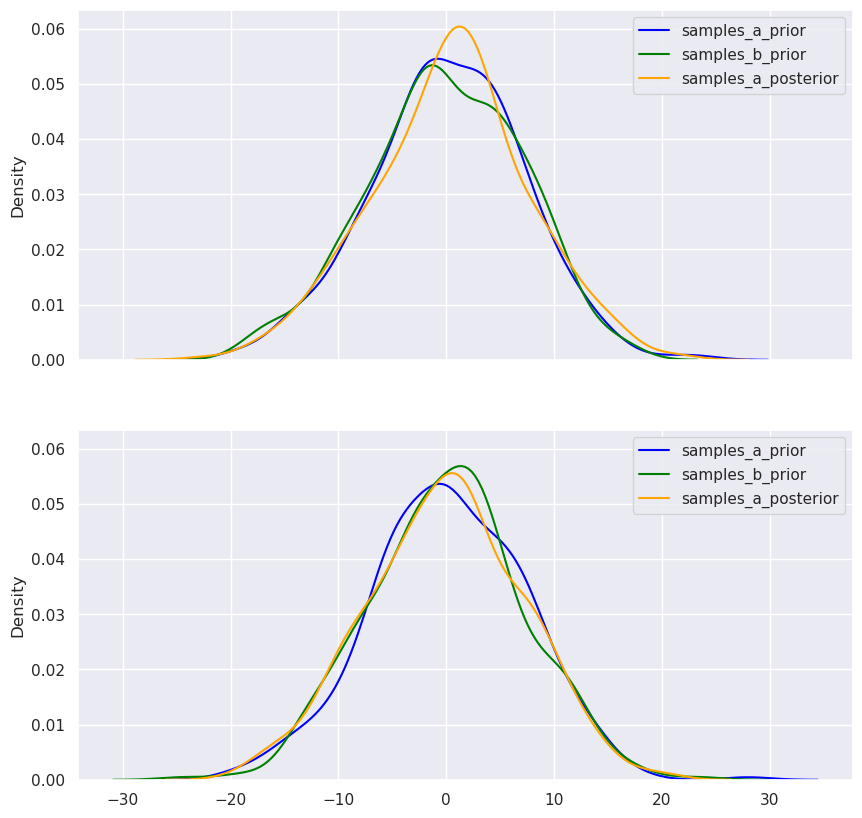

In [5]:
# Visualize the generated prior and posterior samples, individual features
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=1, sharex=True, sharey=True, figsize=(10,10))
axes = axes.flatten()

for i in range(nrows):
    sns.kdeplot(samples_a_weights_prior[:,i], fill=False, color="blue", label="samples_a_prior", ax=axes[i])
    sns.kdeplot(samples_b_weights_prior[:,i], fill=False, color="green", label="samples_b_prior", ax=axes[i])
    sns.kdeplot(samples_a_weights_posterior[:,i], fill=False, color="orange", label="samples_a_posterior", ax=axes[i])
    axes[i].legend()
plt.show()

In [5]:
# # Visualize the generated prior and posterior samples 
# fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10,10))
# axes = axes.flatten()

# sns.kdeplot(x=samples_a_weights_prior[:,0], y=samples_a_weights_prior[:,1], n_levels=20, 
#             cmap="inferno", fill=False, cbar=True, ax=axes[0])

# sns.kdeplot(x=samples_b_weights_prior[:,0], y=samples_b_weights_prior[:,1], n_levels=20, 
#             cmap="inferno", fill=False, cbar=True, ax=axes[1])

# sns.kdeplot(x=samples_a_weights_posterior[:,0], y=samples_a_weights_posterior[:,1], n_levels=20, 
#             cmap="inferno", fill=False, cbar=True, ax=axes[2])
# axes[0].set_title("sample_a_prior")
# axes[1].set_title("sample_b_prior")
# axes[2].set_title("sample_a_posterior")
# plt.show()

### Measure the differences between the prior and samples

* Kernelized two sample test: maximum mean distance with RBF kernel
* Wasserstein distance of two samples
* Difference between the standard deviations (from true mean) of two samples

In [28]:
# Maximum mean distance with RBF kernel
mmd_rbf_prior_a_prior_b = compute_mmd_rbf(samples_a_weights_prior, samples_b_weights_prior)
mmd_rbf_posterior_a_prior_b = compute_mmd_rbf(samples_a_weights_posterior, samples_b_weights_prior)
print(f"MMD between prior a and prior b: {mmd_rbf_prior_a_prior_b:0.5f}")
print(f"MMD between posterior a and prior b: {mmd_rbf_posterior_a_prior_b:0.5f}")

MMD between prior a and prior b: 0.00532
MMD between posterior a and prior b: 0.00517


In [29]:
# Wasserstein distance with RBF kernel
wd_prior_a_prior_b = compute_wasserstein_distance(samples_a_weights_prior, samples_b_weights_prior)
wd_posterior_a_prior_b = compute_wasserstein_distance(samples_a_weights_posterior, samples_b_weights_prior)
print(f"Wasserstein distance between prior a and prior b: {wd_prior_a_prior_b:0.5f}")
print(f"Wasserstein distance between posterior a and prior b: {wd_posterior_a_prior_b:0.5f}")

Wasserstein distance between prior a and prior b: 1.45026
Wasserstein distance between posterior a and prior b: 1.55611


In [30]:
# Difference between the standard deviations (from true mean) of two samples
diff_std_prior_a_prior_b = compute_diff_std(samples_a_weights_prior, samples_b_weights_prior, weights_prior_params[0])
diff_std_posterior_a_prior_b = compute_diff_std(samples_a_weights_posterior, samples_b_weights_prior, weights_prior_params[0])
print(f"Difference standard deviations between between prior a and prior b: {diff_std_prior_a_prior_b:0.5f}")
print(f"Difference standard deviations between posterior a and prior b: {diff_std_posterior_a_prior_b:0.5f}")

Difference standard deviations between between prior a and prior b: 0.04133
Difference standard deviations between posterior a and prior b: 0.67207
